In [2]:
import networkx as nx
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import linprog
from tqdm import tqdm
from itertools import combinations
from collections import defaultdict, deque
import math, random
import heapq
import scipy.sparse as sp
from collections import deque
from joblib import Parallel, delayed
from numba import njit
from typing import Tuple, Dict, List, Set, Sequence, Union
import itertools
import torch_geometric

# 0. Toy Graph Generator

In [57]:
import torch
from torch_geometric.utils import from_networkx

def generate_er_graph(n=100, m=200, p=0.0443, p_edge=0.5, seed=42):
  torch.manual_seed(seed)

  # p = 2.0 * m / (n * (n - 1)) # pick p -> E[|edges|] ~= m

  print(f"p: {p}")

  g_nx = nx.gnp_random_graph(n, p, seed=seed)

  print(g_nx)

  # uniform prob
  nx.set_edge_attributes(g_nx, p_edge, "p")

  # add attribute 'edge_p' of length num_edges
  data = from_networkx(g_nx)

  # for undirected graph: (u->v) (v->u) => 2 * |E| = num_columns in torch data
  data.edge_p = torch.full((data.edge_index.size(1),), p_edge)

  return data

In [58]:
er_test = generate_er_graph(100, 200)
er_test

p: 0.0443
Graph with 100 nodes and 200 edges


Data(edge_index=[2, 400], p=[400], num_nodes=100, edge_p=[400])

# 1. Plain GNN encoder

In [59]:
# utils/graphs.py  (continued)
def epc_naive(data):
    """Fraction of connected pairs in an *unweighted* graph."""
    n = data.num_nodes
    adj = torch.zeros((n, n), dtype=torch.bool)
    adj[data.edge_index[0], data.edge_index[1]] = True
    seen, pairs = torch.zeros(n, dtype=torch.bool), 0
    for v in range(n):
        if not seen[v]:
            stack, comp = [v], []
            seen[v] = True
            while stack:
                cur = stack.pop()
                comp.append(cur)
                for nb in adj[cur].nonzero().view(-1):
                    if not seen[nb]:
                        seen[nb] = True
                        stack.append(nb)
            k = len(comp)
            pairs += k * (k - 1) // 2
    return pairs / (n * (n - 1) // 2)

In [61]:
def component_sampling_epc_mc(G, S, num_samples=10_000,
                              epsilon=None, delta=None, use_tqdm=False):
  """
  Theoretic bounds: compute N = N(epsilon, delta) by the theoretical bound.
  Experimentation:  Otherwise, use the N as input for sample count.
  """

  # Surviving vertex set and its size
  V_remaining = set(G.nodes()) - S
  n_rem = len(V_remaining)

  # base case
  if n_rem < 2:
    return 0.0

  if num_samples is None:
    assert epsilon is not None and delta is not None
    P_E = sum(G.edges[u, v]['p'] for u, v in G.edges())
    coeff = 4 * (math.e - 2) * math.log(2 / delta)
    num_samples = math.ceil(coeff * n_rem * (n_rem - 1) /
                            (epsilon ** 2 * P_E))

  C2 = 0
  it = tqdm(range(num_samples), desc='Component sampling',
            total=num_samples) if use_tqdm else range(num_samples)

  for _ in it:
    u = random.choice(tuple(V_remaining))

    # BFS based on edge probabilities

    visited = {u}
    queue = [u]

    while queue:

      v = queue.pop()
      for w in G.neighbors(v):

        # flip a coin biased by the edge probability
        # w not in deleted nodes
        if w in V_remaining and random.random() < G.edges[v, w]['p']:

          # if w is not visited
          if w not in visited:
              visited.add(w)
              queue.append(w)

    # component counting
    C2 += (len(visited) - 1)

  return (n_rem * C2) / (2 * num_samples)

In [60]:
epc_naive(er_test)

0.9602020202020202

In [62]:
component_sampling_epc_mc(er_test, set())

AttributeError: 'GlobalStorage' object has no attribute 'nodes'

# 2. Gynnasium environment

In [67]:
import gymnasium as gym, copy, torch

class CNDPEnv(gym.Env):
  metadata = {"render_modes": []}

  def __init__(self, data, k=10):
    super().__init__()
    self.orig = data  # PyG data (immutable)
    self.k = k
    self.action_space = gym.spaces.Discrete(data.num_nodes)
    self.observation_space = gym.spaces.Box(
      low=0.0, high=1.0, shape=(data.num_nodes, 2), dtype=float
    )

  # Helpers
  def _deg_norm(self):
    deg = torch.bincount(
        self.data.edge_index[0], minlength=self.data.num_nodes
    ).float()
    return deg / deg.max().clamp(min=1.0)

  def _obs(self):
    return torch.stack([self._deg_norm(), self.mask.float()], dim=1).numpy()
  
  # Gym API

  def reset(self, *, seed=None, options=None):
    super().reset(seed=seed)
    self.data = copy.deepcopy(self.orig)

    # delete nodes
    self.mask = torch.zeros(self.data.num_nodes, dtype=torch.bool)

    # getting EPC naive, steps
    self.steps, self.prev_epc = 0, epc_naive(self.data)

    return self._obs(), {}
  
  def step(self, action):

    if self.mask[action]:
      return self._obs(), -1.0, True, False, {} # illegal
    
    self.mask[action] = True
    keep = (self.data.edge_index[0] != action) & \
           (self.data.edge_index[1] != action)
    
    self.data.edge_index = self.data.edge_index[:, keep]

    self.steps += 1
    epc_now = epc_naive(self.data)
    reward = self.prev_epc - epc_now
    self.prev_epc = epc_now
    terminated = self.steps >= self.k

    return self._obs(), reward, terminated, False, {}


## Sanity Check Env

In [64]:
import numpy as np, pytest

In [78]:
def test_step_shapes():
  g = generate_er_graph()
  env = CNDPEnv(g, k=10)
  obs, _ = env.reset()

  assert obs.shape == (100, 2)
  done = False

  while not done:
    action = env.action_space.sample()
    obs, r, done, _, _ = env.step(action)
    assert np.isfinite(r)

    print(action, r, env.prev_epc)

  # connectivity cannot increase when nodes removed
  assert env.prev_epc <= 1.0

In [79]:
test_step_shapes()

p: 0.0443
Graph with 100 nodes and 200 edges
83 0.01959595959595961 0.9406060606060606
45 0.019393939393939297 0.9212121212121213
31 0.019191919191919204 0.902020202020202
47 0.0377777777777778 0.8642424242424243
61 0.018585858585858595 0.8456565656565657
77 0.01838383838383839 0.8272727272727273
17 0.018181818181818188 0.8090909090909091
61 -1.0 0.8090909090909091


# 3. Plain GCN

In [80]:
import torch.nn as nn
from torch_geometric.nn import GCNConv

class PlainGCN(nn.Module):
  def __init__(self, in_dim=2, hidden=64):
    super().__init__()

    self.conv1 = GCNConv(in_dim, hidden)
    self.conv2 = GCNConv(hidden, hidden)
    self.head = nn.Linear(hidden, 1) # per-node logit

  def forward(self, data, node_feats):
    x = self.conv1(node_feats, data.edge_index).relu()
    x = self.conv2(x, data.edge_index).relu()

    return self.head(x).squeeze(-1)  # shape[N]

In [87]:
def test_gcn_shapes():
  g = generate_er_graph()
  feats = torch.rand(g.num_nodes, 2)
  model = PlainGCN()

  print(model)
  logits = model(g, feats)

  print(logits, logits.shape)
  assert logits.shape == (g.num_nodes, )
  logits.sum().backward()

In [88]:
test_gcn_shapes()

p: 0.0443
Graph with 100 nodes and 200 edges
PlainGCN(
  (conv1): GCNConv(2, 64)
  (conv2): GCNConv(64, 64)
  (head): Linear(in_features=64, out_features=1, bias=True)
)
tensor([-0.0099, -0.0102, -0.0104, -0.0099, -0.0103, -0.0097, -0.0082, -0.0102,
        -0.0099, -0.0115, -0.0098, -0.0106, -0.0090, -0.0118, -0.0099, -0.0097,
        -0.0103, -0.0103, -0.0100, -0.0101, -0.0104, -0.0102, -0.0103, -0.0108,
        -0.0093, -0.0110, -0.0087, -0.0079, -0.0109, -0.0103, -0.0096, -0.0104,
        -0.0100, -0.0103, -0.0094, -0.0106, -0.0105, -0.0105, -0.0113, -0.0101,
        -0.0109, -0.0111, -0.0094, -0.0093, -0.0103, -0.0106, -0.0081, -0.0101,
        -0.0093, -0.0104, -0.0094, -0.0116, -0.0102, -0.0116, -0.0104, -0.0098,
        -0.0123, -0.0107, -0.0094, -0.0099, -0.0108, -0.0105, -0.0103, -0.0104,
        -0.0092, -0.0083, -0.0104, -0.0100, -0.0112, -0.0096, -0.0116, -0.0096,
        -0.0106, -0.0112, -0.0097, -0.0095, -0.0102, -0.0120, -0.0094, -0.0101,
        -0.0101, -0.0102, -0.0

In [89]:
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
import torch.nn as nn, torch

class NodeExtractor(BaseFeaturesExtractor):
    """
    Takes (batch, N, 2) -> runs PlainGCN once (we train on 1 graph per env)
    and returns node logits as a flat vector so SB3 sees `features_dim = N`.
    """
    def __init__(self, observation_space, data):
        n = observation_space.shape[0]
        super().__init__(observation_space, features_dim=n)
        self.data = data
        self.gcn  = PlainGCN(in_dim=2, hidden=64)

    def forward(self, obs):
        n = self.data.num_nodes
        x = obs.view(-1, n, 2)           # SB3 flattens Box, reshape back
        logits = self.gcn(self.data, x[0])   # batch size 1
        return logits


In [90]:
import torch, argparse
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv

def main():
    g = generate_er_graph(p_edge=0.5, seed=0)
    env = DummyVecEnv([lambda: CNDPEnv(g, k=10)])

    policy_kwargs = dict(
        features_extractor_class=NodeExtractor,
        features_extractor_kwargs=dict(data=g),
    )
    model = PPO("MlpPolicy", env,
                policy_kwargs=policy_kwargs,
                learning_rate=3e-4,
                batch_size=256,
                gamma=0.99,
                ent_coef=0.01,
                verbose=1)

    model.learn(total_timesteps=20_000)   # 1-minute smoke run
    model.save("ppo_gcn_er")

In [91]:
main()

p: 0.0443
Graph with 100 nodes and 247 edges
Using cuda device


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument index in method wrapper_CUDA__index_select)

In [127]:
# utils/graphs.py
import torch, networkx as nx
from torch_geometric.utils import from_networkx

def generate_er_graph(n=100, m=200, p_edge=0.5, seed=0):
    torch.manual_seed(seed)
    p = 2.0 * m / (n * (n - 1))        # pick p so E[|E|]≈m
    g_nx = nx.erdos_renyi_graph(n, p, seed=seed)
    nx.set_edge_attributes(g_nx, p_edge, "prob")   # uniform π for now
    data = from_networkx(g_nx)
    data.edge_prob = torch.full((data.edge_index.size(1),), p_edge)
    return data

# utils/graphs.py  (continued)
def epc_naive(data):
    """Fraction of connected pairs in an *unweighted* graph."""
    n = data.num_nodes
    adj = torch.zeros((n, n), dtype=torch.bool)
    adj[data.edge_index[0], data.edge_index[1]] = True
    seen, pairs = torch.zeros(n, dtype=torch.bool), 0
    for v in range(n):
        if not seen[v]:
            stack, comp = [v], []
            seen[v] = True
            while stack:
                cur = stack.pop()
                comp.append(cur)
                for nb in adj[cur].nonzero().view(-1):
                    if not seen[nb]:
                        seen[nb] = True
                        stack.append(nb)
            k = len(comp)
            pairs += k * (k - 1) // 2
    return pairs / (n * (n - 1) // 2)

import gymnasium as gym, copy, torch

class CNDPEnv(gym.Env):
    metadata = {"render_modes": []}

    def __init__(self, data, k=10):
        super().__init__()
        self.orig = data                        # PyG Data (immutable)
        self.k = k
        self.action_space = gym.spaces.Discrete(data.num_nodes)
        self.observation_space = gym.spaces.Box(
            low=0.0, high=1.0, shape=(data.num_nodes, 2), dtype=float
        )

    # ---------- helpers -------------------------------------------------
    def _deg_norm(self):
        deg = torch.bincount(
            self.data.edge_index[0], minlength=self.data.num_nodes
        ).float()
        return deg / deg.max().clamp(min=1.0)

    def _obs(self):
        # deg_norm and mask are both on `device`
        deg = self._deg_norm()
        m   = self.mask.float()
        feats = torch.stack([deg, m], dim=1)
        # convert to CPU numpy for SB3
        return feats.cpu().numpy()

    # ---------- Gym API -------------------------------------------------
    def reset(self, *, seed=None, options=None):
        super().reset(seed=seed)
        device = self.orig.edge_index.device
        self.data = copy.deepcopy(self.orig).to(device)

        # mask on the same device
        self.mask = torch.zeros(self.data.num_nodes, dtype=torch.bool, device=device)
        self.steps = 0
        self.prev_epc = epc_naive(self.data)
        return self._obs(), {}

    def step(self, action):
        if self.mask[action]:
            return self._obs(), -1.0, True, False, {}   # illegal
        self.mask[action] = True
        keep = (self.data.edge_index[0] != action) & \
               (self.data.edge_index[1] != action)
        self.data.edge_index = self.data.edge_index[:, keep]

        self.steps += 1
        epc_now = epc_naive(self.data)
        reward = self.prev_epc - epc_now
        self.prev_epc = epc_now
        terminated = self.steps >= self.k
        return self._obs(), reward, terminated, False, {}


In [129]:
def test_step_shapes():
    g = generate_er_graph()
    env = CNDPEnv(g, k=5)
    obs, _ = env.reset()
    assert obs.shape == (100, 2)
    done = False
    while not done:
        action = env.action_space.sample()
        obs, r, done, _, _ = env.step(action)
        assert np.isfinite(r)
    # connectivity cannot increase when nodes removed
    assert env.prev_epc <= 1.0

test_step_shapes()

In [128]:
class PlainGCN(nn.Module):
    def __init__(self, in_dim=2, hidden=64):
        super().__init__()
        self.conv1 = GCNConv(in_dim, hidden)
        self.conv2 = GCNConv(hidden, hidden)
        self.head  = nn.Linear(hidden, 1)   # per-node logit

    def forward(self, data, node_feats):
        x = self.conv1(node_feats, data.edge_index).relu()
        x = self.conv2(x,           data.edge_index).relu()
        return self.head(x).squeeze(-1)     # shape [N]

In [130]:
def test_gcn_shapes():
    g = generate_er_graph()
    feats = torch.rand(g.num_nodes, 2)
    model = PlainGCN()
    logits = model(g, feats)
    assert logits.shape == (g.num_nodes,)
    logits.sum().backward()  # gradient flows

test_gcn_shapes()

In [131]:
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
import torch.nn as nn, torch

class NodeExtractor(BaseFeaturesExtractor):
    """
    Runs GCN once per observation and returns a *batch x N* tensor.
    SB3 then builds the actor/critic heads on top.
    """
    def __init__(self, observation_space, data):
        n = observation_space.shape[0]
        super().__init__(observation_space, features_dim=n)
        self.register_buffer("edge_index", data.edge_index)
        self.gcn = PlainGCN(in_dim=2, hidden=64)

    def forward(self, obs: torch.Tensor) -> torch.Tensor:
        # obs shape: (batch, N, 2)  – we enforce batch dim here
        batch, n, _ = obs.shape
        assert n == self.edge_index.max().item() + 1, "Node count mismatch"

        # Move edge_index to the same device as obs
        edge_index = self.edge_index.to(obs.device)

        # Run GCN once per batch element
        outputs = []
        for b in range(batch):
            logits = self.gcn(
                data=type("Tmp", (), {"edge_index": edge_index}),
                node_feats=obs[b]
            )                       # (N,)
            outputs.append(logits)

        # Stack so shape = (batch, N)  ← SB3 needs two dims
        return torch.stack(outputs, dim=0)


In [134]:
def main():
    g = generate_er_graph(p_edge=0.5, seed=0)
    env = DummyVecEnv([lambda: CNDPEnv(g, k=10)])

    policy_kwargs = dict(
        features_extractor_class=NodeExtractor,
        features_extractor_kwargs=dict(data=g),
    )
    model = PPO("MlpPolicy", env,
                policy_kwargs=policy_kwargs,
                device="cuda",
                learning_rate=3e-4,
                batch_size=256,
                gamma=0.99,
                ent_coef=0.01,
                verbose=1)

    model.learn(total_timesteps=20_000)   # 1-minute smoke run
    model.save("ppo_gcn_er")

In [135]:
main()

Using cuda device
-----------------------------
| time/              |      |
|    fps             | 359  |
|    iterations      | 1    |
|    time_elapsed    | 5    |
|    total_timesteps | 2048 |
-----------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 168           |
|    iterations           | 2             |
|    time_elapsed         | 24            |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 0.013735736   |
|    clip_fraction        | 0.121         |
|    clip_range           | 0.2           |
|    entropy_loss         | -4.6          |
|    explained_variance   | -0.0010741949 |
|    learning_rate        | 0.0003        |
|    loss                 | -0.021        |
|    n_updates            | 10            |
|    policy_gradient_loss | -0.0159       |
|    value_loss           | 0.14          |
------------------------

In [138]:
from stable_baselines3 import PPO
import numpy as np, torch

model = PPO.load("ppo_gcn_er.zip")
ret = []
for seed in range(50):
    g = generate_er_graph(seed=seed, p_edge=0.5)
    env = CNDPEnv(g, k=10)
    obs, _ = env.reset()
    done, G = False, 0.0
    while not done:
        act, _ = model.predict(obs[None, ...], deterministic=True)
        obs, r, done, _, _ = env.step(act.item())
        G += r
    ret.append(G)

print(f"Mean ΔEPC over 20 graphs: {np.mean(ret):.4f}")

Mean ΔEPC over 20 graphs: -0.9773


In [154]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx
import networkx as nx
import matplotlib.pyplot as plt

# --- 1. GCN Model Definition ---
# This class defines a simple two-layer Graph Convolutional Network.
# It takes graph data as input and outputs an embedding for each node.

class GCN(nn.Module):
    """
    A Graph Convolutional Network that learns node embeddings.
    """
    def __init__(self, in_channels, hidden_channels, out_channels):
        """
        Initializes the GCN layers.
        Args:
            in_channels (int): The number of features for each node at the input.
                               For our case, this can be 1 (a placeholder feature).
            hidden_channels (int): The number of neurons in the hidden layer.
            out_channels (int): The dimension of the final node embeddings.
        """
        super(GCN, self).__init__()
        torch.manual_seed(42)
        # First GCN layer
        self.conv1 = GCNConv(in_channels, hidden_channels)
        # Second GCN layer
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index, edge_weight):
        """
        Defines the forward pass of the network.
        Args:
            x (Tensor): Node feature matrix [num_nodes, in_channels].
            edge_index (Tensor): Graph connectivity in COO format [2, num_edges].
            edge_weight (Tensor): Edge weights (probabilities) [num_edges].

        Returns:
            Tensor: The learned node embeddings [num_nodes, out_channels].
        """
        # Pass through the first GCN layer, then a ReLU activation function
        x = self.conv1(x, edge_index, edge_weight)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training) # Dropout for regularization

        # Pass through the second GCN layer
        x = self.conv2(x, edge_index, edge_weight)
        return x

# --- 2. Example Usage ---

def create_sample_graph(num_nodes=20, edge_prob=0.3, universal_p=0.8):
    """
    Creates a random NetworkX graph with a probability attribute 'p' on each edge.
    """
    # Create a random graph
    G = nx.gnp_random_graph(num_nodes, edge_prob, seed=42)

    # Add the stochastic probability 'p' to each edge
    # For this example, we'll set it to a constant value
    for (u, v) in G.edges():
        G.edges[u, v]['p'] = universal_p

    return G

def main():
    """
    Demonstrates how to use the GCN model on a sample graph.
    """
    # --- Create a sample graph ---
    print("1. Creating a sample NetworkX graph...")
    nx_graph = create_sample_graph()
    num_nodes = nx_graph.number_of_nodes()

    # --- Convert NetworkX graph to PyTorch Geometric Data object ---
    # The GCN model expects data in a specific format.
    # We need node features, the edge list, and edge weights.

    # a. Node features (x): Let's use a simple vector of ones.
    #    Shape: [num_nodes, num_node_features]
    node_features = torch.ones((num_nodes, 1), dtype=torch.float)

    # b. Convert the NetworkX graph. This will extract the edge_index and edge attributes.
    #    We specify which edge attribute to use as the weight ('p').
    pyg_data = from_networkx(nx_graph, group_edge_attrs=['p'])

    # c. Combine node features with the graph structure
    pyg_data.x = node_features
    
    print(pyg_data)
    # The edge weights are now in pyg_data.p
    # Let's rename it to edge_attr for consistency if needed, or just use .p
    edge_weights = pyg_data.p

    print("\n2. Graph converted to PyTorch Geometric format:")
    print(pyg_data)


    # --- Instantiate and run the GCN model ---
    print("\n3. Running the GCN model to get node embeddings...")

    # Model parameters
    input_features = 1
    hidden_dim = 16
    embedding_dim = 8 # The final embedding size for each node

    model = GCN(in_channels=input_features,
                hidden_channels=hidden_dim,
                out_channels=embedding_dim)

    # Put the model in evaluation mode
    model.eval()

    # Get the embeddings. No gradients needed for just a forward pass.
    with torch.no_grad():
        node_embeddings = model(pyg_data.x, pyg_data.edge_index, edge_weights)

    print(f"\n4. Successfully generated embeddings!")
    print(f"Shape of output embeddings: {node_embeddings.shape}")
    print(f"(Shape means: [{num_nodes} nodes] x [{embedding_dim} features per node])")

    # You can inspect the embeddings for the first few nodes
    print("\nSample embeddings (first 5 nodes):")
    print(node_embeddings[:5])


if __name__ == '__main__':
    # Note: To run this, you'll need to install the required libraries:
    # pip install torch torch-geometric networkx matplotlib
    main()



1. Creating a sample NetworkX graph...
Data(edge_index=[2, 134], edge_attr=[134, 1], num_nodes=20, x=[20, 1])


AttributeError: 'GlobalStorage' object has no attribute 'p'

--- Environment Reset ---
Initial EPC: 4757.3650
--- Environment Reset ---
Initial EPC: 4758.8200

Step 1: Taking action -> Remove node 99
  > Reward received: 109.9384
  > New EPC: 4648.8816

Step 2: Taking action -> Remove node 1
  > Reward received: 92.5676
  > New EPC: 4556.3140

Step 3: Taking action -> Remove node 61
  > Reward received: 87.1263
  > New EPC: 4469.1877

Step 4: Taking action -> Remove node 22
  > Reward received: 105.6277
  > New EPC: 4363.5600

Step 5: Taking action -> Remove node 3
  > Reward received: 92.3220
  > New EPC: 4271.2380

Step 6: Taking action -> Remove node 38
  > Reward received: 91.3259
  > New EPC: 4179.9121

Step 7: Taking action -> Remove node 47
  > Reward received: 178.8103
  > New EPC: 4001.1018

Step 8: Taking action -> Remove node 35
  > Reward received: 96.4010
  > New EPC: 3904.7008

Step 9: Taking action -> Remove node 98
  > Reward received: 74.4562
  > New EPC: 3830.2446

Step 10: Taking action -> Remove node 58
  > Reward received: 9

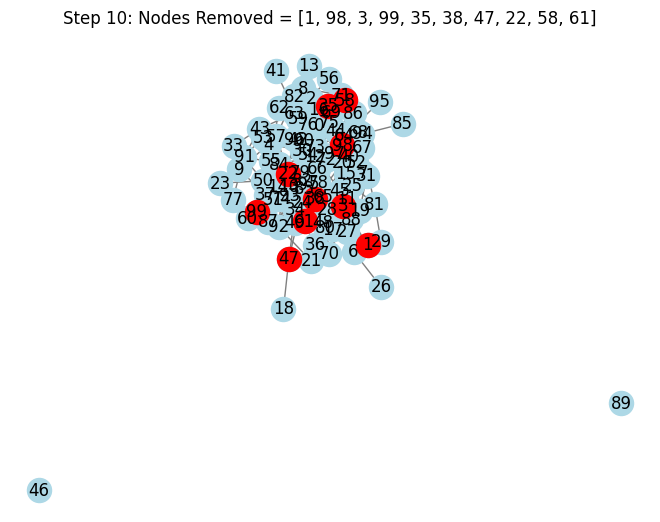

In [153]:
import networkx as nx
import random
import math
from tqdm.auto import tqdm
import copy
from torch_geometric.utils import from_networkx
import torch

# --- 1. The Reward Calculation Function (Provided by you) ---
# This function is the core of our reward signal. It estimates the
# Expected Pairwise Connectivity (EPC) of a given graph state.

def component_sampling_epc_mc(G, S, num_samples=10_000, use_tqdm=False):
  """
  Estimates the Expected Pairwise Connectivity (EPC) via Monte Carlo sampling.
  Args:
      G (nx.Graph): The original graph with 'p' attribute on edges.
      S (set): A set of nodes that have been removed.
      num_samples (int): The number of samples for the Monte Carlo estimation.
  """
  # The set of vertices that remain in the graph
  V_remaining = set(G.nodes()) - S
  n_rem = len(V_remaining)

  # Base case: if less than two nodes remain, no pairs can be connected.
  if n_rem < 2:
    return 0.0

  # This will hold the sum of component sizes (minus 1) for each sample
  C2 = 0
  
  # Set up an iterator, with an optional progress bar
  it = tqdm(range(num_samples), desc='EPC Sampling', leave=False) if use_tqdm else range(num_samples)

  # Convert the remaining nodes to a tuple for faster random choices
  V_remaining_tuple = tuple(V_remaining)

  for _ in it:
    # a) Sample a starting node 'u' uniformly from the remaining nodes
    u = random.choice(V_remaining_tuple)

    # b) Perform a stochastic Breadth-First Search (BFS) to find the component 'u' belongs to
    visited = {u}
    queue = [u]
    head = 0 # Use an index for queue popping, it's faster than list.pop(0)

    while head < len(queue):
      v = queue[head]
      head += 1
      # Check all neighbors of v
      for w in G.neighbors(v):
        # The neighbor must not be a removed node
        if w in V_remaining and w not in visited:
          # Flip a biased coin based on the edge existence probability 'p'
          if random.random() < G.edges[v, w]['p']:
            visited.add(w)
            queue.append(w)

    # c) Add the size of the discovered component (minus 1) to our accumulator
    C2 += (len(visited) - 1)

  # d) Calculate the final EPC estimate based on the formula
  # This formula is derived from the theoretical underpinnings of EPC.
  return (n_rem * C2) / (2 * num_samples)

# --- 2. The Custom Graph Environment ---

class GraphEnv:
    """
    A custom Reinforcement Learning environment for the critical node detection problem.
    It behaves like a standard OpenAI Gym environment.
    """
    def __init__(self, initial_graph: nx.Graph, num_to_remove: int, epc_samples: int = 5000):
        """
        Initializes the environment.
        Args:
            initial_graph (nx.Graph): The starting graph. Must have 'p' on edges.
            num_to_remove (int): The number of nodes to remove in one episode.
            epc_samples (int): Number of samples for the EPC calculation.
        """
        self.initial_graph = initial_graph
        self.num_to_remove = num_to_remove
        self.epc_samples = epc_samples
        self.reset()

    def reset(self):
        """
        Resets the environment to its initial state for a new episode.
        Returns:
            The initial state representation.
        """
        print("--- Environment Reset ---")
        # Use a deep copy to avoid modifying the original graph
        self.G = copy.deepcopy(self.initial_graph)
        self.nodes_removed = set()
        self.num_steps = 0
        
        # Calculate the EPC of the graph before any nodes are removed
        self.current_epc = component_sampling_epc_mc(self.G, self.nodes_removed, self.epc_samples)
        print(f"Initial EPC: {self.current_epc:.4f}")
        
        return self._get_state()

    def step(self, action_node: int):
        """
        Executes one time step within the environment.
        Args:
            action_node (int): The node to be removed.
        
        Returns:
            A tuple (next_state, reward, done, info).
        """
        if action_node not in self.G.nodes() or action_node in self.nodes_removed:
            raise ValueError(f"Invalid action: Node {action_node} is not a valid choice.")
        
        # --- Action Execution ---
        self.nodes_removed.add(action_node)
        self.num_steps += 1
        
        # --- Reward Calculation ---
        # The reward is the reduction in EPC caused by removing the node.
        epc_after_removal = component_sampling_epc_mc(self.G, self.nodes_removed, self.epc_samples)
        reward = self.current_epc - epc_after_removal
        self.current_epc = epc_after_removal # Update the current EPC

        # --- Episode Termination Condition ---
        done = self.num_steps >= self.num_to_remove
        
        return self._get_state(), reward, done, {}

    def _get_state(self):
        """
        Generates the state representation for the agent.
        This includes the graph structure and a mask for valid actions.
        """
        # Convert the current graph state to a PyTorch Geometric Data object
        # This is the format our GCN will expect
        if not self.G.nodes: # Handle empty graph case
             return None, None

        temp_g = copy.deepcopy(self.G)
        temp_g.remove_nodes_from(self.nodes_removed)
        
        if not temp_g.nodes: # Handle case where all nodes are removed
            return None, None
            
        pyg_data = from_networkx(temp_g, group_edge_attrs=['p'])
        pyg_data.x = torch.ones((temp_g.number_of_nodes(), 1)) # Placeholder features
        
        # The agent needs to know which nodes are still available to pick.
        # We create a mapping from the new dense index in pyg_data to original node labels
        node_mapping = {i: node for i, node in enumerate(temp_g.nodes())}
        
        return pyg_data, node_mapping

    def render(self):
        """
        (Optional) A function to visualize the environment state.
        """
        pos = nx.spring_layout(self.initial_graph)
        nx.draw(self.initial_graph, pos, with_labels=True, node_color='lightblue', edge_color='gray')
        nx.draw_networkx_nodes(self.initial_graph, pos, nodelist=self.nodes_removed, node_color='red')
        plt.title(f"Step {self.num_steps}: Nodes Removed = {list(self.nodes_removed)}")
        plt.show()

# --- 3. Demonstration of Usage ---

def create_sample_graph(num_nodes=100, edge_prob=0.045, universal_p=0.7):
    """Creates a random NetworkX graph."""
    G = nx.gnp_random_graph(num_nodes, edge_prob, seed=42)
    for (u, v) in G.edges():
        G.edges[u, v]['p'] = universal_p
    return G

def main():
    """Shows how to use the GraphEnv."""
    # --- Setup ---
    base_graph = create_sample_graph(num_nodes=100, edge_prob=0.045, universal_p=1.0)
    # The agent's goal is to remove 5 nodes to minimize EPC
    env = GraphEnv(initial_graph=base_graph, num_to_remove=10, epc_samples=10_000)

    # --- Interaction Loop (using random actions for now) ---
    state, node_mapping = env.reset()
    done = False
    total_reward = 0
    
    while not done:
        if state is None: break
            
        # The policy network would go here. For now, we pick a random valid action.
        # The action must be one of the original node labels from the available nodes.
        action_idx = random.choice(list(node_mapping.keys()))
        action_node = node_mapping[action_idx]
        
        print(f"\nStep {env.num_steps + 1}: Taking action -> Remove node {action_node}")
        
        # Environment steps forward
        (next_state, node_mapping), reward, done, _ = env.step(action_node)
        
        print(f"  > Reward received: {reward:.4f}")
        print(f"  > New EPC: {env.current_epc:.4f}")
        
        state = next_state
        total_reward += reward

    print(f"\n--- Episode Finished ---")
    print(f"Total reward accumulated: {total_reward:.4f}")
    print(f"Nodes removed: {sorted(list(env.nodes_removed))}")
    env.render()


if __name__ == '__main__':
    main()



In [155]:
class GCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index, edge_weight=None):
        x = self.conv1(x, edge_index, edge_weight)
        x = F.relu(x)
        x = self.conv2(x, edge_index, edge_weight)
        return x

In [157]:
class ActorCritic(nn.Module):
    """
    The combined Actor-Critic network. It uses a shared GCN base to process
    the graph state and then splits into two heads: one for policy (Actor)
    and one for value estimation (Critic).
    """
    def __init__(self, in_channels, hidden_channels, embedding_dim):
        super(ActorCritic, self).__init__()
        
        # Shared GCN base for feature extraction
        self.gcn_base = GCN(in_channels, hidden_channels, embedding_dim)
        
        # Actor head: Outputs logits for the action probability distribution
        # It takes the node embeddings and maps them to a single score per node.
        self.actor_head = nn.Linear(embedding_dim, 1)
        
        # Critic head: Outputs a single value for the entire state
        # It aggregates the node embeddings (e.g., by mean) and maps to a state value.
        self.critic_head = nn.Linear(embedding_dim, 1)

    def forward(self, pyg_data):
        """
        A forward pass through the network.
        Args:
            pyg_data (torch_geometric.data.Data): The graph state.
        
        Returns:
            logits (Tensor): Raw scores for each node (for the Actor).
            value (Tensor): The estimated value of the state (for the Critic).
        """
        # Get node embeddings from the shared GCN base
        # x is [num_nodes, embedding_dim]
        x = self.gcn_base(pyg_data.x, pyg_data.edge_index, pyg_data.p)

        # --- Actor ---
        # Get a score for each node. Shape: [num_nodes, 1] -> [num_nodes]
        logits = self.actor_head(x).squeeze(-1)
        
        # --- Critic ---
        # To get a single value for the state, we can average the embeddings
        # and pass them through the critic head.
        state_embedding = x.mean(dim=0) # Shape: [embedding_dim]
        value = self.critic_head(state_embedding) # Shape: [1]
        
        return logits, value

In [ ]:
import torch
import torch.nn as nn
from torch.distributions import Categorical
import torch.optim as optim
import torch.nn.functional as F
from torch_geometric.data import Data, Batch
from torch_geometric.utils import from_networkx
import networkx as nx
import numpy as np
from tqdm import tqdm

class ActorCritic(nn.Module):
    """
    The combined Actor-Critic network. It uses a shared GCN base to process
    the graph state and then splits into two heads: one for policy (Actor)
    and one for value estimation (Critic).
    """
    def __init__(self, in_channels, hidden_channels, embedding_dim):
        super(ActorCritic, self).__init__()
        
        # Shared GCN base for feature extraction
        self.gcn_base = GCN(in_channels, hidden_channels, embedding_dim)
        
        # Actor head: Outputs logits for the action probability distribution
        self.actor_head = nn.Linear(embedding_dim, 1)
        
        # Critic head: Outputs a single value for the entire state
        self.critic_head = nn.Linear(embedding_dim, 1)

    def forward(self, pyg_data):
        """
        A forward pass through the network.
        Args:
            pyg_data (torch_geometric.data.Data): The graph state.
        
        Returns:
            logits (Tensor): Raw scores for each node (for the Actor).
            value (Tensor): The estimated value of the state (for the Critic).
        """
        # Get node embeddings from the shared GCN base
        # x is [num_nodes, embedding_dim]
        # FIX: Access edge weights via `edge_attr`, not `p`.
        edge_attr = pyg_data.edge_attr if hasattr(pyg_data, 'edge_attr') else None
        x = self.gcn_base(pyg_data.x, pyg_data.edge_index, edge_attr)

        # --- Actor ---
        # Get a score for each node. Shape: [num_nodes, 1] -> [num_nodes]
        logits = self.actor_head(x).squeeze(-1)
        
        # --- Critic ---
        # To get a single value for the state, we can average the embeddings
        # and pass them through the critic head.
        state_embedding = x.mean(dim=0) # Shape: [embedding_dim]
        value = self.critic_head(state_embedding) # Shape: [1]
        
        return logits, value

# --- 2. PPO Agent ---

class PPOAgent:
    def __init__(self, env, hidden_dim=32, embedding_dim=16, lr=0.0005, gamma=0.99, K_epochs=5, eps_clip=0.2):
        self.env = env
        self.gamma = gamma
        self.eps_clip = eps_clip
        self.K_epochs = K_epochs
        
        # Instantiate the Actor-Critic network
        self.policy = ActorCritic(1, hidden_dim, embedding_dim)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=lr)
        
        # Instantiate a separate, "old" policy network for PPO calculations
        self.policy_old = ActorCritic(1, hidden_dim, embedding_dim)
        self.policy_old.load_state_dict(self.policy.state_dict())
        
        self.mse_loss = nn.MSELoss()
        self.memory = []

    def clear_memory(self):
        self.memory = []

    def store_experience(self, state, action, log_prob, reward, done, node_mapping):
        self.memory.append((state, action, log_prob, reward, done, node_mapping))

    def select_action(self, pyg_state, node_mapping):
        """
        Selects an action (a node to remove) from the current policy.
        """
        if pyg_state is None: return None, None, None
        # Get logits and state value from the "old" policy
        logits, _ = self.policy_old(pyg_state)
        
        # Create a probability distribution over the available actions (nodes)
        action_probs = F.softmax(logits, dim=-1)
        dist = Categorical(action_probs)
        
        # Sample an action index from the distribution
        action_idx = dist.sample()
        
        # Get the original node label from the mapping
        action_node = node_mapping[action_idx.item()]
        
        return action_node, action_idx.item(), dist.log_prob(action_idx)

    def update(self):
        """
        Updates the policy using the collected experiences in memory.
        """
        # --- 1. Prepare data for update ---
        rewards = []
        discounted_reward = 0
        
        for state, action, log_prob, reward, done, node_mapping in reversed(self.memory):
            if done:
                discounted_reward = 0
            discounted_reward = reward + (self.gamma * discounted_reward)
            rewards.insert(0, discounted_reward)

        rewards = torch.tensor(rewards, dtype=torch.float32)
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-7)

        old_states = [exp[0] for exp in self.memory]
        old_actions = torch.tensor([exp[1] for exp in self.memory], dtype=torch.long)
        old_log_probs = torch.tensor([exp[2] for exp in self.memory], dtype=torch.float32)

        # --- 2. Optimize policy for K epochs ---
        for _ in range(self.K_epochs):
            old_states_batch = Batch.from_data_list(old_states)
            logits, values = self.policy(old_states_batch)
            values = values.squeeze()
            
            log_probs = []
            entropies = []
            current_pos = 0
            for i, state in enumerate(old_states):
                num_nodes = state.num_nodes
                graph_logits = logits[current_pos : current_pos + num_nodes]
                dist = Categorical(F.softmax(graph_logits, dim=-1))
                log_probs.append(dist.log_prob(torch.tensor(old_actions[i])))
                entropies.append(dist.entropy())
                current_pos += num_nodes

            log_probs = torch.stack(log_probs)
            entropies = torch.stack(entropies)

            # --- 3. Calculate PPO Loss ---
            ratios = torch.exp(log_probs - old_log_probs.detach())
            advantages = rewards - values.detach()
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1 - self.eps_clip, 1 + self.eps_clip) * advantages
            loss = -torch.min(surr1, surr2) + 0.5 * self.mse_loss(values, rewards) - 0.01 * entropies
            
            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()
            
        self.policy_old.load_state_dict(self.policy.state_dict())
        self.clear_memory()

In [151]:
def train():
    print("--- Starting Training ---")
    # --- Hyperparameters ---
    num_episodes = 200
    num_nodes_to_remove = 10
    update_timestep = 20  # Update policy every n steps
    
    # --- Setup ---
    base_graph = create_sample_graph(num_nodes=100, edge_prob=0.045, universal_p=1.0)
    env = GraphEnv(initial_graph=base_graph, num_to_remove=num_nodes_to_remove, epc_samples=1000)
    agent = PPOAgent(env)
    
    time_step = 0
    episode_rewards = []

    # --- Training Loop ---
    for i_episode in tqdm(range(1, num_episodes + 1)):
        state, node_mapping = env.reset()
        current_ep_reward = 0
        
        for t in range(num_nodes_to_remove):
            time_step += 1
            
            # Agent selects an action
            action_node, action_idx, log_prob = agent.select_action(state, node_mapping)
            
            # Environment takes a step
            (next_state, next_node_mapping), reward, done, _ = env.step(action_node)
            
            # Store experience
            agent.store_experience(state, action_idx, log_prob, reward, done, node_mapping)
            
            # Update the policy if it's time
            if time_step % update_timestep == 0:
                print(f"\nUpdating policy at timestep {time_step}...")
                agent.update()
            
            state = next_state
            node_mapping = next_node_mapping
            current_ep_reward += reward
            
            if done:
                break
        
        episode_rewards.append(current_ep_reward)
        if i_episode % 10 == 0:
            avg_reward = np.mean(episode_rewards[-10:])
            print(f"Episode {i_episode}\tAverage Reward: {avg_reward:.4f}")

    print("--- Training Finished ---")


In [152]:
train()

--- Starting Training ---
--- Environment Reset ---
Initial EPC: 4743.3000


  0%|          | 0/200 [00:00<?, ?it/s]

--- Environment Reset ---
Initial EPC: 4772.4000


AttributeError: 'GlobalStorage' object has no attribute 'p'